<a href="https://colab.research.google.com/github/ddekun/Intro_Neural_Networks/blob/lesson6/lesson6/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в нейронные сети

### Урок 6. Сегментация

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?
2. Попробуйте свои силы в задаче Carvana на Kaggle: https://www.kaggle.com/c/carvana-image-masking-challenge/overview

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
import numpy as np
from PIL import Image
import tensorflow as tf
import cv2
import os, fnmatch

In [ ]:
# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

**Загрузка данных**

In [ ]:
PAHT_label = 'train_masks/'
PAHT_image = 'train/'

In [ ]:
imag_label = os.listdir(PAHT_label)
imag = os.listdir(PAHT_image)

In [ ]:
imag.sort()
imag[:10]

['00087a6bd4dc_01.jpg',
 '00087a6bd4dc_02.jpg',
 '00087a6bd4dc_03.jpg',
 '00087a6bd4dc_04.jpg',
 '00087a6bd4dc_05.jpg',
 '00087a6bd4dc_06.jpg',
 '00087a6bd4dc_07.jpg',
 '00087a6bd4dc_08.jpg',
 '00087a6bd4dc_09.jpg',
 '00087a6bd4dc_10.jpg']

In [ ]:
imag_label.sort()
imag_label[:10]

['00087a6bd4dc_01_mask.gif',
 '00087a6bd4dc_02_mask.gif',
 '00087a6bd4dc_03_mask.gif',
 '00087a6bd4dc_04_mask.gif',
 '00087a6bd4dc_05_mask.gif',
 '00087a6bd4dc_06_mask.gif',
 '00087a6bd4dc_07_mask.gif',
 '00087a6bd4dc_08_mask.gif',
 '00087a6bd4dc_09_mask.gif',
 '00087a6bd4dc_10_mask.gif']

In [ ]:
len(imag)

5088

In [ ]:
images = []
segments = []
image_size = (200,600)
for i_name in imag[:100]:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))

for i_name in imag_label[:100]:
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

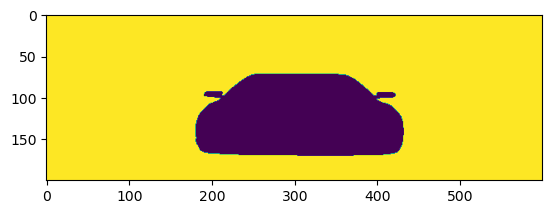

In [ ]:
def Color2index(y):
  arr_col=[[255,255,255],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1
    i += 1

  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()

In [ ]:
# входные данные
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

# print(xTrain_Test.shape)

# print(yTrain_Test.shape)

N = int(xTrain_Test.shape[0]*.8)

yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

print(xTrain.shape)
print(yTrain.shape)

(80, 200, 600, 3)
(80, 200, 600, 2)


**Модель**

In [ ]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [ ]:
modelC = Unet(2, (200, 600, 3))

plot_model(modelC, to_file='modelC.png')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 600, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_76 (BatchN  (None, 200, 600, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

 activation_83 (Activation)     (None, 25, 75, 512)  0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 block4_conv2 (Conv2D)          (None, 25, 75, 512)  2359808     ['activation_83[0][0]']          
                                                                                                  
 batch_normalization_84 (BatchN  (None, 25, 75, 512)  2048       ['block4_conv2[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 activation_84 (Activation)     (None, 25, 75, 512)  0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 block4_conv3 (Conv2D)          (None, 25, 75, 512)  2359808     ['activation_84[0][0]']          
          

 concatenate_14 (Concatenate)   (None, 200, 600, 12  0           ['activation_92[0][0]',          
                                8)                                'activation_77[0][0]']          
                                                                                                  
 conv2d_32 (Conv2D)             (None, 200, 600, 64  73792       ['concatenate_14[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 200, 600, 64  256        ['conv2d_32[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_93 (Activation)     (None, 200, 600, 64  0           ['batch_normalization_93[0][0]'] 
          

In [ ]:
history = modelC.fit(xTrain, yTrain, epochs=30, batch_size=1, validation_data=(xTest, yTest))

Epoch 1/30
80/80 [==============================] - 258s 3s/step - loss: 0.1048 - dice_coef: 0.9386 - val_loss: 0.2741 - val_dice_coef: 0.9597
Epoch 2/30
80/80 [==============================] - 252s 3s/step - loss: 0.0322 - dice_coef: 0.9809 - val_loss: 0.8109 - val_dice_coef: 0.9218
Epoch 3/30
80/80 [==============================] - 253s 3s/step - loss: 0.0296 - dice_coef: 0.9829 - val_loss: 0.7289 - val_dice_coef: 0.9261
Epoch 4/30
80/80 [==============================] - 260s 3s/step - loss: 0.0254 - dice_coef: 0.9848 - val_loss: 0.0801 - val_dice_coef: 0.9658
Epoch 5/30
80/80 [==============================] - 250s 3s/step - loss: 0.0195 - dice_coef: 0.9886 - val_loss: 0.7570 - val_dice_coef: 0.8889
Epoch 6/30
80/80 [==============================] - 247s 3s/step - loss: 0.0255 - dice_coef: 0.9855 - val_loss: 1.7084 - val_dice_coef: 0.8592
Epoch 7/30
80/80 [==============================] - 246s 3s/step - loss: 0.0222 - dice_coef: 0.9869 - val_loss: 0.7050 - val_dice_coef: 0.8900

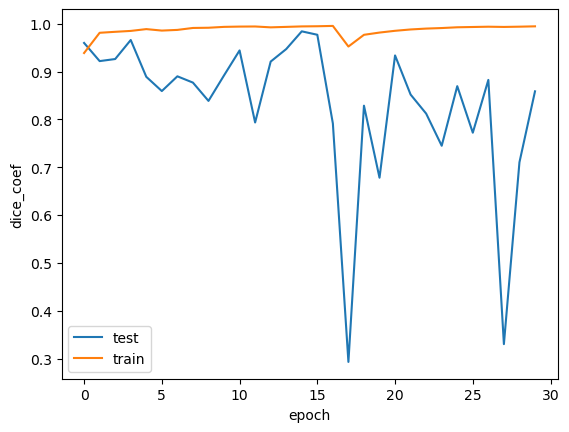

In [ ]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

**Претренированная модель**

In [ ]:
pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [ ]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])


    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])


    # UP 3


    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4


    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [ ]:
modelU = unet_pre_train(num_classes = 2, input_shape= (200, 600, 3))

plot_model(modelU, to_file='modelU.png')

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 75, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 150, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 300, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                       

                                                                                                  
 conv2d_38 (Conv2D)             (None, 50, 150, 128  147584      ['activation_98[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_99 (BatchN  (None, 50, 150, 128  512        ['conv2d_38[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_99 (Activation)     (None, 50, 150, 128  0           ['batch_normalization_99[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_tr

In [ ]:
historyU = modelU.fit(xTrain, yTrain, epochs=30, batch_size=3,
                      validation_data=(xTrain, yTrain),
                      callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 )])

Epoch 1/30
27/27 [==============================] - 102s 4s/step - loss: 0.2366 - dice_coef: 0.8626 - val_loss: 0.2610 - val_dice_coef: 0.8891
Epoch 2/30
27/27 [==============================] - 99s 4s/step - loss: 0.0917 - dice_coef: 0.9440 - val_loss: 0.4493 - val_dice_coef: 0.8692
Epoch 3/30
27/27 [==============================] - 99s 4s/step - loss: 0.0438 - dice_coef: 0.9746 - val_loss: 0.4041 - val_dice_coef: 0.8782
Epoch 4/30
27/27 [==============================] - 99s 4s/step - loss: 0.0288 - dice_coef: 0.9829 - val_loss: 0.1245 - val_dice_coef: 0.9425
Epoch 5/30
27/27 [==============================] - 99s 4s/step - loss: 0.0209 - dice_coef: 0.9876 - val_loss: 0.0489 - val_dice_coef: 0.9732
Epoch 6/30
27/27 [==============================] - 99s 4s/step - loss: 0.0167 - dice_coef: 0.9901 - val_loss: 0.0293 - val_dice_coef: 0.9833
Epoch 7/30
27/27 [==============================] - 99s 4s/step - loss: 0.0143 - dice_coef: 0.9916 - val_loss: 0.0201 - val_dice_coef: 0.9876
Epoch

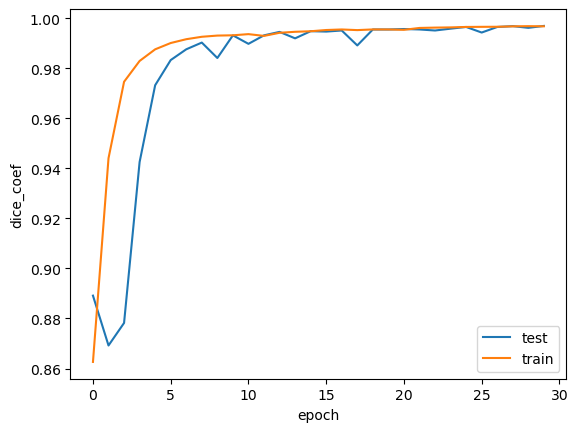

In [ ]:
plt.plot(historyU.history['val_dice_coef'],label = 'test')
plt.plot(historyU.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

**Вывод**

Претренированная модель показывает лучшие результаты (более гладкая кривая обучения).